# GemPy Workshop
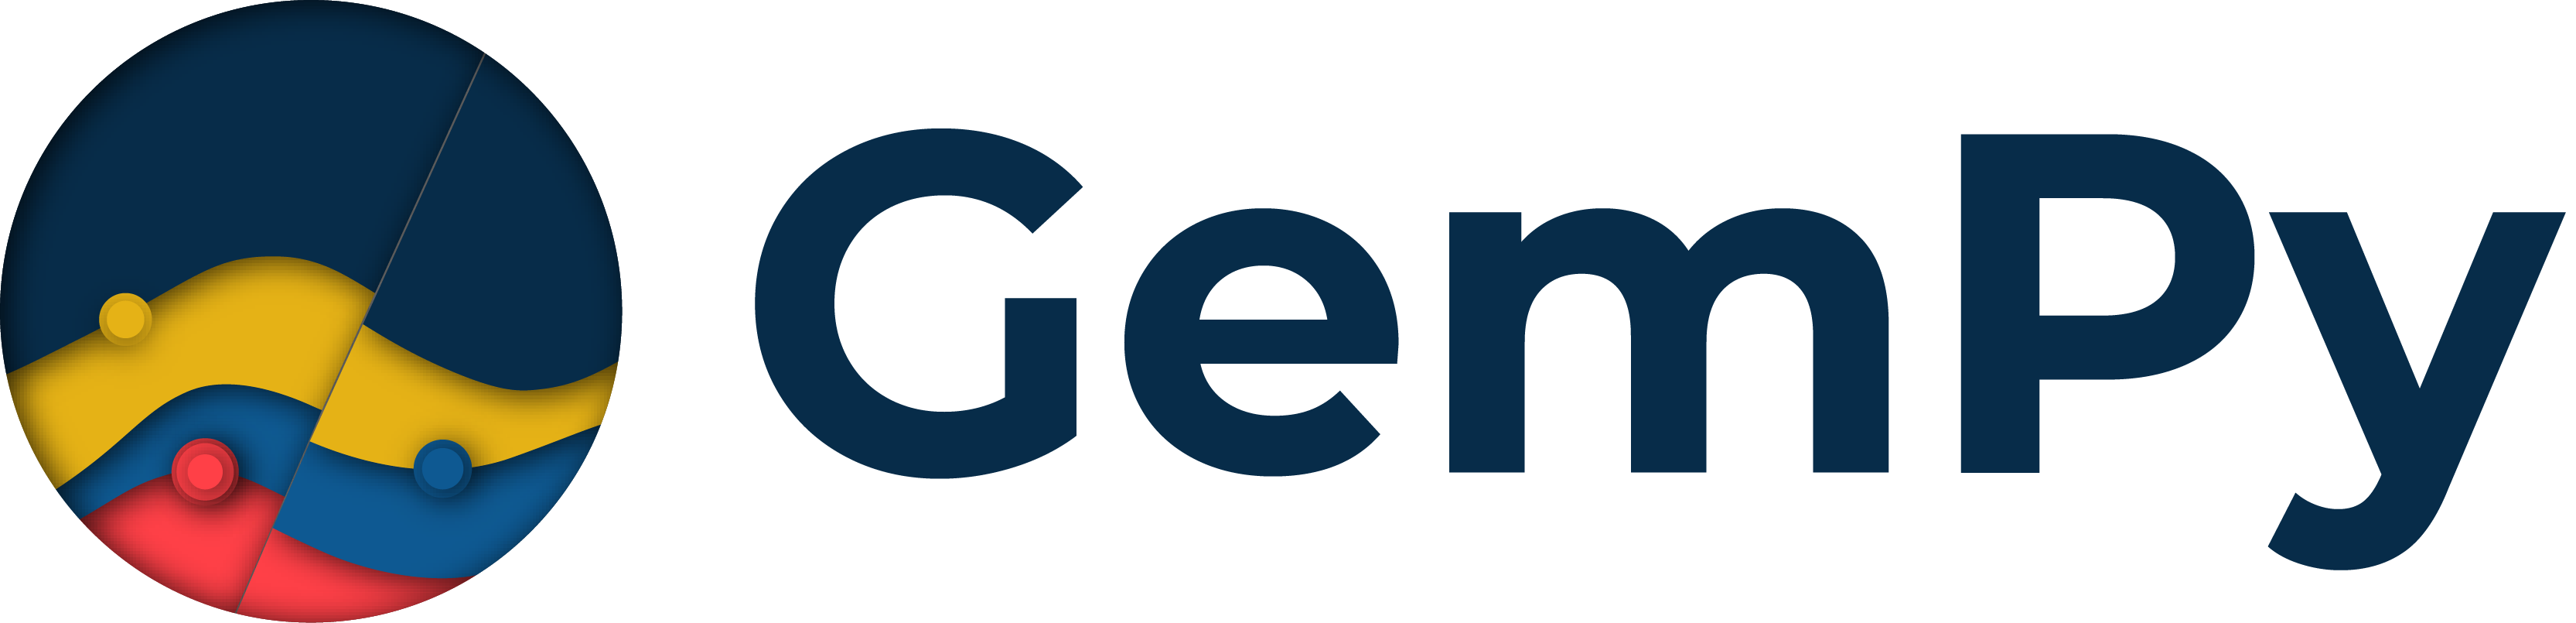

## Installation

0. https://docs.conda.io/en/latest/miniconda.html
1. Open conda prompt (Windows) or terminal (Linux/MacOS)
2. `$ conda create --name gu python==3.7.5`
0. Activate enviromet: `$ conda activate gu`
3. Installing gempy: https://docs.gempy.org/installation.html
4. clone the repo:
    `git clone https://github.com/cgre-aachen/gempy_workshops.git`
0. `$ conda install jupyter notebook`
5. `$ jupyter notebook`

---
For this notebook we will need some additional packages:

Extra:
`$ pip install subsurface, pooch, striplog, welly`


In [ ]:
!pip install subsurface
!pip install pooch
!pip install git+https://github.com/Leguark/striplog.git
!pip install welly
!pip install sklearn

## Subsurface: Centralizing data management for the GeoScientific Stack 

Subsurface is a package in development aiming to unify at a low level the data structures used from multilpe packages in geoscience for Python. It heavily relies on `xarray` to store data.

Besides the data structures themselves `subsurface` provides custom logic to read - and in the future write - to 3rd party formats outside the Python ecosystem. In this notebook we are going to use `subsurface` to import borehole data from csv files:

In [ ]:
import pooch
from striplog import Component
import pandas as pd
import numpy as np

In [ ]:
import subsurface as sb
from subsurface.reader import ReaderFilesHelper
from subsurface.reader.wells import read_collar, read_lith, read_survey, WellyToSubsurfaceHelper, welly_to_subsurface

We use `pooch` to download the dataset into a temp file:

In [ ]:
base_url = "https://raw.githubusercontent.com/softwareunderground/subsurface/main/tests/data/borehole/"

raw_borehole_data_csv = pooch.retrieve(url=base_url + 'kim_ready.csv',
                                       known_hash="efa90898bb435daa15912ca6f3e08cd3285311923a36dbc697d2aafebbafa25f")


Now we can use `subsurface` function to help us reading csv files into pandas dataframes that the package can understand. Since the combination of styles data is provided can highly vary from project to project, `subsurface` provides some *helpers* functions to parse different combination of .csv

In [ ]:
reading_collars = ReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        index_col="name",
        usecols=['x', 'y', 'altitude', "name"]
    )
reading_collars

In [ ]:
collar = read_collar(reading_collars)

collar

In [ ]:
survey = read_survey(
    ReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        index_col="name",
        usecols=["name", "md"]
    )
)

survey

In [ ]:
lith = read_lith(
    ReaderFilesHelper(
        file_or_buffer=raw_borehole_data_csv,
        usecols=['name', 'top', 'base', 'formation'],
        columns_map={'top': 'top',
                     'base': 'base',
                     'formation': 'component lith',
                     }
    )
)

lith


### Welly

Welly is a family of classes to facilitate the loading, processing, and analysis of subsurface wells and well data, such as striplogs, formation tops, well log curves, and synthetic seismograms.

We are using welly to convert pandas data frames into classes to manipulate well data. The final goal is to extract 3D coordinates and properties for multiple wells.

The class `WellyToSubsurfaceHelper` contains the methods to create a `welly` project and export it to a `subsurface` data class.

In [ ]:
wts = WellyToSubsurfaceHelper(collar_df=collar, survey_df=survey, lith_df=lith)

In the field p is stored a welly project (https://github.com/agile-geoscience/welly/blob/master/tutorial/04_Project.ipynb)and we can use it to explore and visualize properties of each well.

In [ ]:
wts.p

In [ ]:
stripLog = wts.p[0].data['lith']
stripLog

In [ ]:
stripLog.plot()

In [ ]:
welly_well = wts.p[0].data["lith_log"]
welly_well

## Welly to Subsurface 

Welly is a very powerful tool to inspect well data but it was not design for 3D. However they have a method to export XYZ coordinates of each of the well that we can take advanatage of to create a `subsurface.UnstructuredData` object. This object is one of the core data class of `subsurface` and we will use it from now on to keep working in 3D.

In [ ]:
formations = ["topo", "etchegoin", "macoma", "chanac", "mclure",
              "santa_margarita", "fruitvale",
              "round_mountain", "olcese", "freeman_jewett", "vedder", "eocene",
              "cretaceous",
              "basement", "null"]

unstruct = welly_to_subsurface(wts, table=[Component({'lith': l}) for l in formations])
unstruct

At each core `UstructuredData` is a wrapper of a `xarray.Dataset`. Although slightly flexible, any `UnstructuredData` will contain 4 `xarray.DataArray` objects containing vertex, cells, cell attributes and vertex attibutes. This is the minimum amount of information necessary to work in 3D. 

In [ ]:
unstruct.data["vertex"]

In [ ]:
unstruct.data["cells"]

In [ ]:
unstruct.data.cell_attrs

From an `UnstructuredData` we can construct *elements*. *elements* are a higher level construct and includes the definion of type of geometric representation - e.g. points, lines, surfaces, etc. For the case of borehole we will use LineSets. *elements* have a very close relation to `vtk` data structures what enables easily to plot the data using `pyvista`

In [ ]:
element = sb.LineSet(unstruct)
pyvista_mesh = sb.visualization.to_pyvista_line(element, radius=50)

# Plot default LITH
interactive_plot =sb.visualization.pv_plot([pyvista_mesh], background_plotter=True)

## Finding the boreholes bases

`GemPy` interpolates the bottom of a unit, therefore we need to be able to extract those points to be able tointerpolate them. `xarray`, `pandas` and `numpy` are using the same type of memory representation what makes possible to use the same or at least similar methods to manipulate the data to our will. 

Lets find the base points of each well:

In [ ]:
# Creating references to the xarray.DataArray
cells_attr = unstruct.data.cell_attrs
cells = unstruct.data.cells
vertex = unstruct.data.vertex

In [ ]:
# Find vertex points at the boundary of two units
# Marking each vertex
bool_prop_change = cells_attr.values[1:] != cells_attr.values[:-1]
# Getting the index of the vertex
args_prop_change = np.where(bool_prop_change)[0]
# Getting the attr values at those points 
vals_prop_change = cells_attr[args_prop_change]
vals_prop_change.to_pandas()

In [ ]:
# Getting the vertex values at those points
vertex_args_prop_change = cells[args_prop_change, 1]
interface_points = vertex[vertex_args_prop_change]
interface_points

In [ ]:
# Creating a new UnstructuredData
interf_us= sb.UnstructuredData.from_array(vertex=interface_points.values, cells="points",
                                          cells_attr=vals_prop_change.to_pandas())
interf_us

This new `UnstructuredData` object instead containing data that represent lines, contain point data at the bottom of each unit. We can plot it very similar as before:

In [ ]:
element = sb.PointSet(interf_us)
pyvista_mesh = sb.visualization.to_pyvista_points(element)
interactive_plot.add_mesh(pyvista_mesh)

## GemPy: Initialize model

The first step to create a GemPy model is create a `gempy.Model` object that will
contain all the other data structures and necessary functionality. In addition
 for this example we will define a *regular grid* since the beginning.
This is the grid where we will interpolate the 3D geological model.

GemPy is based on a **meshless interpolator**. In practice this means that we can
interpolate any point in a 3D space. However, for convenience, we have built some
standard grids for different purposes. At the current day the standard grids are:

- **Regular grid**: default grid mainly for general visualization
- **Custom grid**: GemPy's wrapper to interpolate on a user grid
- **Topography**: Topographic data use to be of high density. Treating it as an independent
  grid allow for high resolution geological maps
- **Sections**: If we predefine the section 2D grid we can directly interpolate at those
  locations for perfect, high resolution estimations
- **Center grids**: Half sphere grids around a given point at surface. This are specially tuned
  for geophysical forward computations

In [ ]:
import gempy as gp
geo_model = gp.create_model("getting started")
geo_model.set_regular_grid(extent=[275619, 323824, 3914125, 3961793, -3972.6, 313.922], resolution=[50,50,50])

GemPy core code is written in Python. However for efficiency and gradient based
machine learning most of heavy computations happen in optimize compile code,
 either C or CUDA for GPU.

To do so, GemPy rely on the library `Theano`. To guarantee maximum optimization
`Theano` requires to compile the code for every Python kernel. The compilation is
done by calling the following line at any point (before computing the model):

In [ ]:
gp.set_interpolator(geo_model, theano_optimizer='fast_compile', verbose=[])

## Making a model step by step.

The temptation at this point is to bring all the points into `gempy` and just interpolate. However, often that strategy results in ill posed problems due to noise or irregularities in the data. `gempy` has been design to being able to iterate rapidly and therefore a much better workflow use to be creating the model step by step.

To do that, lets define a function that we can pass the name of the formation and get the assotiated vertex. Grab from the `interf_us` the XYZ coordinates of the first layer:

In [ ]:
def get_interface_coord_from_surfaces(surface_names: list, verbose=False):
    
    df = pd.DataFrame(columns=["X", "Y", "Z", "surface"])
    
    for e, surface_name in enumerate(surface_names):
        # The properties in subsurface start at 1
        val_property = e + 1
        # Find the cells with the surface id
        args_from_first_surface = np.where(vals_prop_change == val_property)[0]    
        if verbose: print(args_from_first_surface)
        # Find the vertex
        points_from_first_surface = interface_points[args_from_first_surface]
        if verbose: print(points_from_first_surface)
        
        # xarray.DataArray to pandas.DataFrame
        surface_pandas = points_from_first_surface.to_pandas()
        
        # Add formation column
        surface_pandas["surface"] = surface_name
        df = df.append(surface_pandas)
    
    return df.reset_index()

### Surfaces

GemPy is a surface based interpolator. This means that all the input data we add has to be refereed to a surface. The
 surfaces always mark the **bottom** of a unit. 
 
This is a list with the formations names for this data set.

In [ ]:
formations

Lets add the first two (remember we always need a basement defined).

In [ ]:
geo_model.add_surfaces(formations[:2])

Using the function defined above we just extract the surface points for ***topo*:

In [ ]:
gempy_surface_points = get_interface_coord_from_surfaces(["topo"])
gempy_surface_points

And we can set them into the `gempy` model:

In [ ]:
geo_model.set_surface_points(gempy_surface_points, update_surfaces=False)
geo_model.update_to_interpolator()

In [ ]:
gp.plot.plot_2d(geo_model)

The **minimum amount of input data** to interpolate anything in `gempy` is:

a) 2 surface points per surface

b) One orientation per series.

Lets add an orientation:

In [ ]:
geo_model.add_orientations(X=300000, Y=3930000, Z=0, surface="topo", pole_vector=(0,0,1))

GemPy depends on multiple data objects to store all the data structures necessary
to construct an structural model. To keep all the necessary objects in sync the
class `gempy.ImplicitCoKriging` (which `geo_model` is instance of) will provide the
necessary methods to update these data structures coherently.

At current state (gempy 2.2), the data classes are:

- `gempy.SurfacePoints`
- `gempy.Orientations`
- `gempy.Surfaces`
- `gempy.Stack` (combination of `gempy.Series` and `gempy.Faults`)
- `gempy.Grid`
- `gempy.AdditionalData`
- `gempy.Solutions`

Today we will look into details only some of these classes but what is important
to notice is that you can access these objects as follows:

In [ ]:
geo_model.additional_data

In [ ]:
gp.compute_model(geo_model)

In [ ]:
g3d = gp.plot_3d(geo_model, plotter_type="background")

In [ ]:
g3d.p.add_mesh(pyvista_mesh)

## Second layer

In [ ]:
geo_model.add_surfaces(formations[2])

In [ ]:
gempy_surface_points = get_interface_coord_from_surfaces(formations[:2])
geo_model.set_surface_points(gempy_surface_points, update_surfaces=False)
geo_model.update_to_interpolator()

In [ ]:
gp.compute_model(geo_model)

In [ ]:
live_plot = gp.plot_3d(geo_model, plotter_type="background", show_results=True)

In [ ]:
live_plot.toggle_live_updating()

### Trying to fix the model: Multiple Geo. Features/Series

In [ ]:

geo_model.add_features("Formations")

In [ ]:
geo_model.map_stack_to_surfaces({"Form1": ["etchegoin", "macoma"]}, set_series=False)

In [ ]:
geo_model.add_orientations(X=300000, Y=3930000, Z=0, surface="etchegoin", pole_vector=(0,0,1), idx=1)

In [ ]:
gp.compute_model(geo_model)

In [ ]:
gp.plot_3d(geo_model, plotter_type="background", show_lith=False, ve=5)

## Last layer for today

In [ ]:
geo_model.add_surfaces(formations[3:5])

In [ ]:
f_last = formations[:4]
f_last

In [ ]:
gempy_surface_points = get_interface_coord_from_surfaces(f_last)
geo_model.set_surface_points(gempy_surface_points, update_surfaces=False)
geo_model.update_to_interpolator()

In [ ]:
gp.compute_model(geo_model)

In [ ]:
p3d_4 = gp.plot_3d(geo_model, plotter_type="background", show_lith=False, ve=5)

In [ ]:
geo_model.add_orientations(X=321687.059770, Y=3.945955e+06, Z=0, surface="etchegoin", pole_vector=(0,0,1), idx=1)
gp.compute_model(geo_model)
p3d_4.plot_surfaces()

In [ ]:
geo_model.add_orientations(X=277278.652995, Y=3.929298e+06, Z=0, surface="etchegoin", pole_vector=(0,0,1), idx=2)
gp.compute_model(geo_model)
p3d_4.plot_surfaces()

## Adding many more orientations

In [ ]:
# find neighbours
neighbours = gp.select_nearest_surfaces_points(geo_model, geo_model._surface_points.df, 2)

# calculate all fault orientations
gp.set_orientation_from_neighbours_all(geo_model, neighbours)

In [ ]:
gp.compute_model(geo_model)

In [ ]:
p3d_4.plot_orientations()
p3d_4.plot_surfaces()

In [ ]:
p3d_4.p.add_mesh(pyvista_mesh)

-----

## Thank you for your attention


#### Extra Resources

Page:
https://www.gempy.org/

Paper:
https://www.gempy.org/theory

Gitub:
https://github.com/cgre-aachen/gempy

#### Further training and collaborations
https://www.terranigma-solutions.com/

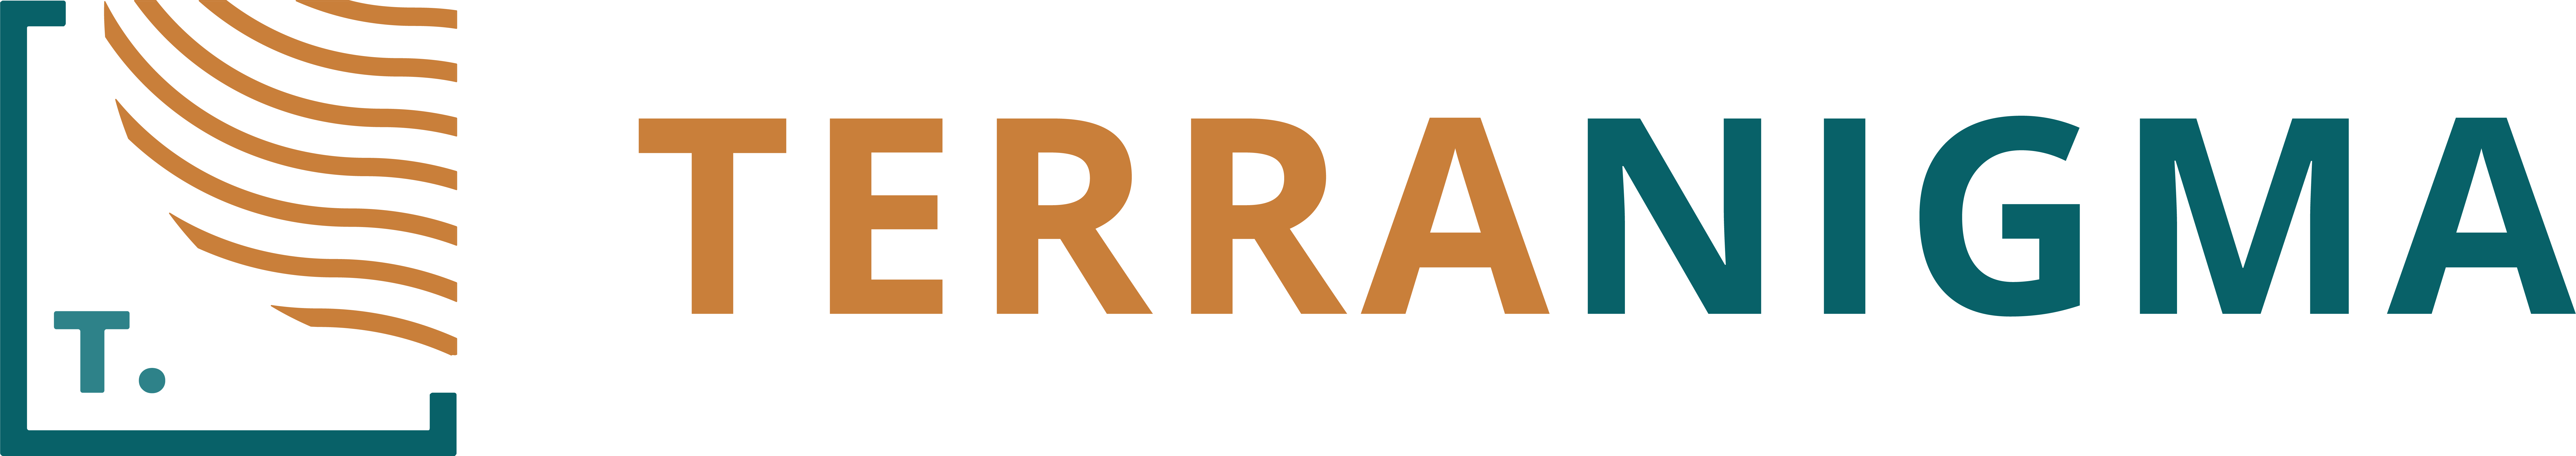